# PERFORMANCE OF HEDGED CREDIT

AUTHOR: [@sparshsah](https://github.com/sparshsah)

In [90]:
# utils: ignore

from typing import Union, Optional
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DEFAULT_R_KIND: str = "log"
SHORT_HORIZON: int = 3
DEFAULT_WINDOW_KIND: str = "full"
EST_HORIZON: int = 42
DEFAULT_AVG_KIND: str = "mean"
# observe info at `t`, trade on it the course of `t+1`, earn at `t+2`
IMPL_LAG: int = 2
# approx duration of a 2Y t-bond
DEFAULT_BOND_DUR: float = 1.93
DEFAULT_VOL: float = 0.10
DAYCOUNTS = {"Bd": 1, "BW": 5, "Bm": 21, "BQ": 65, "BY": 261}

FloatT = Union[float, pd.Series, pd.DataFrame]


def get_r_from_px(px: pd.Series, kind: str=DEFAULT_R_KIND) -> pd.Series:
    r = {
        "arith": px.diff(),
        "log": np.log(px/px.shift()),
        "geom": px/px.shift()-1
    }
    r = r[kind]
    return r

def get_r_from_yield(
        yld: pd.Series,
        dur: float=DEFAULT_BOND_DUR,
        annualizer=DAYCOUNTS["BY"]
    ) -> pd.Series:
    """Approximation for a constant-duration bond, assuming log yields."""
    one_day_carry_exposed_return = yld.shift() / annualizer
    # remember: duration is in years, so we must use annualized yields
    delta_yld = yld - yld.shift()
    duration_exposed_return = -dur * (delta_yld)
    r = one_day_carry_exposed_return + duration_exposed_return
    return r


def get_xr(r: pd.Series, tbill_r: pd.Series) -> pd.Series:
    r = r - tbill_r.reindex(index=r.index).rename(r.name)
    return r


def get_cum_r(r: pd.Series, kind: str=DEFAULT_R_KIND) -> pd.Series:
    px = {
        "arith": r.cumsum(),
        "log": r.cumsum(),
        "geom": (1+r).cumprod() - 1
    }
    px = px[kind]
    return px
    


def _get_window(
        ser: pd.Series,
        kind: str=DEFAULT_WINDOW_KIND,
        horizon: int=EST_HORIZON,
        min_periods: Optional[int]=None
    ) -> pd.core.window.Window:
    min_periods = int(horizon/2) if min_periods is None else min_periods
    window = {
        "full": ser,
        "expanding": ser.expanding(min_periods=min_periods),
        "ewm": ser.ewm(com=horizon, min_periods=min_periods),
        "rolling": ser.rolling(window=horizon, min_periods=min_periods)
    }
    window = window[kind]
    return window


def _get_est_avg(
        y: pd.Series,
        window_kind: str=DEFAULT_WINDOW_KIND,
        horizon: int=EST_HORIZON,
        avg_kind: str=DEFAULT_AVG_KIND
    ) -> pd.Series:
    window = _get_window(y, kind=window_kind, horizon=horizon)
    est_avg = {
        "mean": window.mean(),
        # "median": window.median()
    }
    est_avg = est_avg[avg_kind]
    return est_avg


def get_est_er(
        r: pd.Series,
        kind: str=DEFAULT_WINDOW_KIND,
        annualizer: int=DAYCOUNTS["BY"]
    ) -> pd.Series:
    est_avg = _get_est_avg(y=r, window_kind=kind)
    est_er = est_avg * annualizer
    return est_er


def _get_est_cov(
        y: pd.Series, x: pd.Series,
        short_horizon: int=SHORT_HORIZON,
        demean: bool=False,
        kind: str=DEFAULT_WINDOW_KIND,
        horizon: int=EST_HORIZON
    ) -> pd.Series:
    """Simple GARCH estimate of covariance.
    
    The estimate at time `t` incorporates information up to and including `t`.
    
    sources
    -------
    https://github.com/sparshsah/foggy-demo/blob/main/demo/stats/bias-variance-risk.ipynb.pdf
    https://faculty.fuqua.duke.edu/~charvey/Research/Published_Papers/P135_The_impact_of.pdf
    """
    y_deviations = y
    x_deviations = x
    if demean:
        y_deviations = y_deviations - _get_window(y_deviations, kind=kind, horizon=horizon).mean()
        x_deviations = x_deviations - _get_window(x_deviations, kind=kind, horizon=horizon).mean()
    # adjust for CLT! std of n-sum inverse-scales w/ n**0.5
    y_deviations = y_deviations.rolling(window=short_horizon).sum() / short_horizon**0.5
    x_deviations = x_deviations.rolling(window=short_horizon).sum() / short_horizon**0.5
    co_deviations = y_deviations * x_deviations
    est_cov = _get_window(co_deviations, kind=kind, horizon=horizon).mean()
    return est_cov

def _get_est_std(y: pd.Series, kind: str=DEFAULT_WINDOW_KIND) -> pd.Series:
    est_var = _get_est_cov(y=y, x=y, kind=kind)
    est_std = est_var **0.5
    return est_std

def _get_est_corr(y: pd.Series, x: pd.Series) -> pd.Series:
    est_cov = _get_est_cov(y=y, x=x)
    est_y_std = _get_est_std(y=y)
    est_x_std = _get_est_std(y=x)
    est_corr = est_cov / (est_y_std * est_x_std)
    return est_corr


def get_est_vol(
        r: pd.Series,
        kind: str=DEFAULT_WINDOW_KIND,
        annualizer: int=DAYCOUNTS["BY"]
    ) -> pd.Series:
    est_std = _get_est_std(y=r, kind=kind)
    est_vol = est_std * annualizer**0.5
    return est_vol


def get_est_sharpe(r: pd.Series, kind: str=DEFAULT_WINDOW_KIND):
    est_er = get_est_er(r=r, kind=kind)
    est_vol = get_est_vol(r=r, kind=kind)
    est_sharpe = est_er / est_vol
    return est_sharpe


def get_est_beta(of: pd.Series, on: pd.Series) -> pd.Series:
    est_corr = _get_est_corr(y=of, x=on)
    est_of_std = _get_est_std(y=of)
    est_on_std = _get_est_std(y=on)
    est_beta = est_corr * (est_of_std / est_on_std)
    return est_beta


def _get_est_perf_stats(r: pd.Series) -> pd.Series:
    perf_stats = [
        ("Sharpe", get_est_sharpe(r=r)),
        ("ER", get_est_er(r=r)),
        ("Vol", get_est_vol(r=r))
    ]
    perf_stats = OrderedDict(perf_stats)
    perf_stats = pd.Series(perf_stats)
    return perf_stats


def _chart(r: pd.Series) -> pd.Series:
    cum_r = get_cum_r(r=r)
    cum_r.plot(title=r.name)
    plt.show()
    est_perf_stats = _get_est_perf_stats(r=r)
    print(est_perf_stats)
    return est_perf_stats



def get_vol_targeted(r: pd.Series, tgt_vol: float=DEFAULT_VOL) -> pd.Series:
    """(Implementably) modulate volatility.
    
    Input should be excess-of-interest-rate returns.
    """
    est_vol = get_est_vol(r=r, kind="ewm")
    # at the end of each session, we check the data,
    # then trade up or down to hit this much leverage...
    est_required_leverage = tgt_vol / est_vol
    # ... thence, over the next session, we earn this much return
    # (based on yesterday's estimate of required leverage)
    leverage_at_t = est_required_leverage.shift(IMPL_LAG)
    levered_r_at_t = leverage_at_t * r
    return levered_r_at_t


def get_hedged(base: pd.Series, out: pd.Series) -> pd.Series:
    """(Implementably) short out `base`'s exposure to `out`."""
    # at the end of each day, we submit an order to short this much `out`
    est_beta = get_est_beta(of=base, on=out)
    # this is weight as $ notional / $ NAV
    hedge_pos_at_t = est_beta.shift(IMPL_LAG)
    hedge_r_at_t = hedge_pos_at_t * out
    hedged_base_r_at_t = base - hedge_r_at_t
    return hedged_base_r_at_t

In [91]:
def get_bond_r_from_yld(fname: str, name: str, dur: float=DEFAULT_BOND_DUR, xr: bool=False) -> pd.Series:
    yld = pd.read_csv(fname, index_col=0, parse_dates=True).sort_index().squeeze()
    yld = yld.apply(lambda y: None if y == "." else y)
    yld = yld.ffill(limit=3)
    yld = yld.astype(float)
    yld = yld / 100  # comes as pctg
    yld = yld.rename(name)
    r = get_r_from_yield(yld=yld, dur=dur)
    if xr:
        r = get_xr(r=r, tbill_r=TBILL_R)
    return r

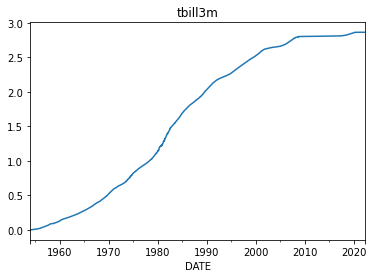

Sharpe    6.217156
ER        0.041920
Vol       0.006743
dtype: float64


Sharpe    6.217156
ER        0.041920
Vol       0.006743
dtype: float64

In [94]:
TBILL_R = get_bond_r_from_yld(fname="data/fred-3m-tbill-secondary-yield.csv", name="tbill3m", dur=0.25)
_chart(TBILL_R)

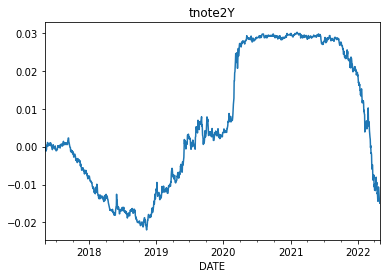

Sharpe   -0.275923
ER       -0.002992
Vol       0.010842
dtype: float64


Sharpe   -0.275923
ER       -0.002992
Vol       0.010842
dtype: float64

In [95]:
TY_R = get_bond_r_from_yld(fname="data/fred-2y-treasury-mkt-yield.csv", name="tnote2Y", dur=2, xr=True)
_chart(TY_R)